# TPC DS scale factor 10 - Apache Spark acceleration on GPU with RAPIDS Spark

based on https://colab.research.google.com/github/LucaCanali/Miscellaneous/blob/master/Performance_Testing/TPCDS_PySpark/Labs_and_Notes/TPCDS_PySpark_getstarted.ipynb#scrollTo=6bab7772

# Install packages

In [1]:
spark_version='3.5.0'
rapids_version='24.08.1'
scala_version='2.12'

In [3]:
%pip install --quiet \
  tpcds_pyspark \
  pyspark=={spark_version} \
  sparkmeasure \
  pandas \
  matplotlib

Note: you may need to restart the kernel to use updated packages.


# Import modules

In [4]:
import os
from importlib.resources import files
from pyspark.sql import SparkSession
from tpcds_pyspark import TPCDS
import pandas as pd

In [5]:
tpcds_pyspark_files = files('tpcds_pyspark')

# Download TPC-DS 10GiB Scale Parquet Dataset

In [7]:
if not os.path.isdir('tpcds_10'):
  if not os.path.isfile('tpcds_10.zip'):
    !wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/TPCDS/tpcds_10.zip
  !unzip -q tpcds_10.zip

# Init a SparkSession with RAPIDS Spark

In [8]:
spark = (
    SparkSession.builder
      .appName('TPCDS PySpark RAPIDS=ON/OFF')
      .config('spark.driver.memory', '5g')
      .config('spark.plugins', 'com.nvidia.spark.SQLPlugin')
      .config('spark.jars', tpcds_pyspark_files.joinpath(f"spark-measure_{scala_version}-0.24.jar"))
      .config('spark.jars.packages', f"com.nvidia:rapids-4-spark_{scala_version}:{rapids_version}")
      .getOrCreate()
)


24/10/21 22:11:14 WARN Utils: Your hostname, e780a48-lcedt resolves to a loopback address: 127.0.1.1; using 10.112.215.249 instead (on interface enp36s0f0)
24/10/21 22:11:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/gshegalov/gits/NVIDIA/spark-rapids-examples/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/gshegalov/.ivy2/cache
The jars for the packages stored in: /home/gshegalov/.ivy2/jars
com.nvidia#rapids-4-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-42694f4a-ddfe-49c0-bd6a-451be03fe403;1.0
	confs: [default]
	found com.nvidia#rapids-4-spark_2.12;24.08.0 in central
:: resolution report :: resolve 75ms :: artifacts dl 3ms
	:: modules in use:
	com.nvidia#rapids-4-spark_2.12;24.08.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-42694f4a-ddfe-49c0-bd6a-

# Verify SQL Acceleration on GPU can be enabled by checking the query plan and the GPU RAM in the "Resources" tab

In [9]:
spark.conf.set('spark.rapids.sql.enabled', True)
sum_df = spark.range(1000).selectExpr('SUM(*)')
sum_df.collect()
sum_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   GpuColumnarToRow false, [loreId=22]
   +- GpuHashAggregate (keys=[], functions=[gpubasicsum(id#0L, LongType, false)]), filters=ArrayBuffer(None)) [loreId=21]
      +- GpuShuffleCoalesce 1073741824, [loreId=20]
         +- ShuffleQueryStage 0
            +- GpuColumnarExchange gpusinglepartitioning$(), ENSURE_REQUIREMENTS, [plan_id=64], [loreId=17]
               +- GpuHashAggregate (keys=[], functions=[partial_gpubasicsum(id#0L, LongType, false)]), filters=ArrayBuffer(None)) [loreId=16]
                  +- GpuRange (0, 1000, step=1, splits=64)
+- == Initial Plan ==
   HashAggregate(keys=[], functions=[sum(id#0L)])
   +- Exchange SinglePartition, ENSURE_REQUIREMENTS, [plan_id=11]
      +- HashAggregate(keys=[], functions=[partial_sum(id#0L)])
         +- Range (0, 1000, step=1, splits=64)




In [10]:
# https://github.com/LucaCanali/Miscellaneous/tree/master/Performance_Testing/TPCDS_PySpark/tpcds_pyspark/Queries

# queries = None to run all (takes much longer)
queries = None
queries = [
    'q14a',
    'q14b',
    'q23a',
    'q23b',
    'q24a',
    'q24b',
    'q88',
]


In [11]:
tpcds = TPCDS(data_path="./tpcds_10", num_runs=1, queries_repeat_times=1, queries=queries)

sparkMeasure jar path: /home/gshegalov/gits/NVIDIA/spark-rapids-examples/.venv/lib/python3.10/site-packages/tpcds_pyspark/spark-measure_2.12-0.24.jar
TPCDS queries path: /home/gshegalov/gits/NVIDIA/spark-rapids-examples/.venv/lib/python3.10/site-packages/tpcds_pyspark/Queries


24/10/21 22:11:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Register TPC-DS tables before running queries

In [12]:
tpcds.map_tables()

Creating temporary view catalog_returns


24/10/21 22:11:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Creating temporary view catalog_sales
Creating temporary view inventory
Creating temporary view store_returns
Creating temporary view store_sales
Creating temporary view web_returns
Creating temporary view web_sales
Creating temporary view call_center
Creating temporary view catalog_page
Creating temporary view customer
Creating temporary view customer_address
Creating temporary view customer_demographics
Creating temporary view date_dim
Creating temporary view household_demographics
Creating temporary view income_band
Creating temporary view item
Creating temporary view promotion
Creating temporary view reason
Creating temporary view ship_mode
Creating temporary view store
Creating temporary view time_dim
Creating temporary view warehouse
Creating temporary view web_page
Creating temporary view web_site


# Measure Apache Spark CPU

In [13]:
tpcds.spark.conf.set('spark.rapids.sql.enabled', False)
tpcds.run_TPCDS()


Run 0 - query q14a - attempt 0 - starting...


Job finished
...Start Time = 2024-10-21 22:12:00
...Elapsed Time = 10.03 sec
...Executors Run Time = 168.35 sec
...Executors CPU Time = 93.27 sec
...Executors JVM GC Time = 40.84 sec
...Average Active Tasks = 16.8

Run 0 - query q14b - attempt 0 - starting...


Job finished
...Start Time = 2024-10-21 22:12:14
...Elapsed Time = 5.46 sec
...Executors Run Time = 90.27 sec
...Executors CPU Time = 58.49 sec
...Executors JVM GC Time = 21.05 sec
...Average Active Tasks = 16.5

Run 0 - query q23a - attempt 0 - starting...


Job finished
...Start Time = 2024-10-21 22:12:21
...Elapsed Time = 9.09 sec
...Executors Run Time = 205.74 sec
...Executors CPU Time = 143.75 sec
...Executors JVM GC Time = 44.4 sec
...Average Active Tasks = 22.6

Run 0 - query q23b - attempt 0 - starting...


24/10/21 22:12:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/21 22:12:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/21 22:12:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Job finished
...Start Time = 2024-10-21 22:12:32
...Elapsed Time = 11.36 sec
...Executors Run Time = 253.7 sec
...Executors CPU Time = 164.27 sec
...Executors JVM GC Time = 69.89 sec
...Average Active Tasks = 22.3

Run 0 - query q24a - attempt 0 - starting...


Job finished
...Start Time = 2024-10-21 22:12:44
...Elapsed Time = 4.14 sec
...Executors Run Time = 75.63 sec
...Executors CPU Time = 44.65 sec
...Executors JVM GC Time = 18.85 sec
...Average Active Tasks = 18.3

Run 0 - query q24b - attempt 0 - starting...


Job finished
...Start Time = 2024-10-21 22:12:50
...Elapsed Time = 3.69 sec
...Executors Run Time = 73.43 sec
...Executors CPU Time = 37.65 sec
...Executors JVM GC Time = 21.29 sec
...Average Active Tasks = 19.9

Run 0 - query q88 - attempt 0 - starting...


Job finished
...Start Time = 2024-10-21 22:12:54
...Elapsed Time = 1.2 sec
...Executors Run Time = 52.51 sec
...Executors CPU Time = 22.98 sec
...Executors JVM GC Time = 25.34 sec
...Average Active Tasks = 43.9


In [14]:
cpu_grouped_results = tpcds.grouped_results_pdf[['query', 'elapsedTime']].copy()

In [15]:
cpu_grouped_results

,query,elapsedTime
0,q14a,10028
1,q14b,5455
2,q23a,9087
3,q23b,11357
4,q24a,4136
5,q24b,3691
6,q88,1197


# Measure Apache Spark GPU

In [16]:
tpcds.spark.conf.set('spark.rapids.sql.enabled', True)
tpcds.run_TPCDS()


Run 0 - query q14a - attempt 0 - starting...


24/10/21 22:13:13 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec

24/10/21 22:13:14 WARN MultiFileReaderThreadPool: Configuring the file reader thread pool with a max of 64 threads instead of spark.rapids.sql.multiThreadedRead.numThreads = 20
24/10/21 22:13:14 WARN MultiFileReaderThreadPool: Configuring the file reader thread pool with a max of 64 threads instead of spark.rapids.sql.multiThreadedRead.numThreads = 20
24/10/21 22:13:14 WARN MultiFileReaderThreadPool: Configuring the file reader thread pool with a max of 64 threads instead of spark.rapids.sql.multiThreadedRead.numThreads = 20
24/10/21 22:13:14 WARN MultiFileReaderThreadPool: Configuring the file reader thread pool with a max of 64 threads instead of spark.rapids.sql.multiThreadedRead.numThreads = 20
24/10/21 22:13:14 WARN MultiFileReaderThreadPool: Configuring the file read

Job finished
...Start Time = 2024-10-21 22:13:11
...Elapsed Time = 6.25 sec
...Executors Run Time = 127.82 sec
...Executors CPU Time = 18.73 sec
...Executors JVM GC Time = 9.48 sec
...Average Active Tasks = 20.5

Run 0 - query q14b - attempt 0 - starting...


24/10/21 22:13:21 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-21 22:13:21
...Elapsed Time = 2.95 sec
...Executors Run Time = 84.9 sec
...Executors CPU Time = 13.88 sec
...Executors JVM GC Time = 3.41 sec
...Average Active Tasks = 28.8

Run 0 - query q23a - attempt 0 - starting...


24/10/21 22:13:26 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-21 22:13:25
...Elapsed Time = 3.36 sec
...Executors Run Time = 90.6 sec
...Executors CPU Time = 21.99 sec
...Executors JVM GC Time = 4.16 sec
...Average Active Tasks = 27.0

Run 0 - query q23b - attempt 0 - starting...


24/10/21 22:13:30 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-21 22:13:30
...Elapsed Time = 5.04 sec
...Executors Run Time = 184.36 sec
...Executors CPU Time = 25.23 sec
...Executors JVM GC Time = 6.25 sec
...Average Active Tasks = 36.6

Run 0 - query q24a - attempt 0 - starting...


24/10/21 22:13:37 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-21 22:13:36
...Elapsed Time = 3.92 sec
...Executors Run Time = 72.56 sec
...Executors CPU Time = 12.05 sec
...Executors JVM GC Time = 2.0 sec
...Average Active Tasks = 18.5

Run 0 - query q24b - attempt 0 - starting...


24/10/21 22:13:42 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-21 22:13:41
...Elapsed Time = 3.57 sec
...Executors Run Time = 64.82 sec
...Executors CPU Time = 11.71 sec
...Executors JVM GC Time = 2.34 sec
...Average Active Tasks = 18.2

Run 0 - query q88 - attempt 0 - starting...


24/10/21 22:13:46 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-21 22:13:46
...Elapsed Time = 2.07 sec
...Executors Run Time = 105.91 sec
...Executors CPU Time = 4.17 sec
...Executors JVM GC Time = 1.88 sec
...Average Active Tasks = 51.3


# Show Speedup Factors achieved by GPU


In [17]:
gpu_grouped_results = tpcds.grouped_results_pdf[['query', 'elapsedTime']].copy()

In [18]:
gpu_grouped_results

,query,elapsedTime
0,q14a,6246
1,q14b,2948
2,q23a,3356
3,q23b,5036
4,q24a,3919
5,q24b,3570
6,q88,2066


In [19]:
res = pd.merge(cpu_grouped_results, gpu_grouped_results, on='query', how='inner', suffixes=['_cpu', '_gpu'])

In [20]:
res['speedup'] = res['elapsedTime_cpu'] / res['elapsedTime_gpu']

In [21]:
res = res.sort_values(by='elapsedTime_cpu', ascending=False)

<Axes: title={'center': 'TPC-DS query elapsedTime on CPU vs GPU (lower is better)'}, xlabel='query'>

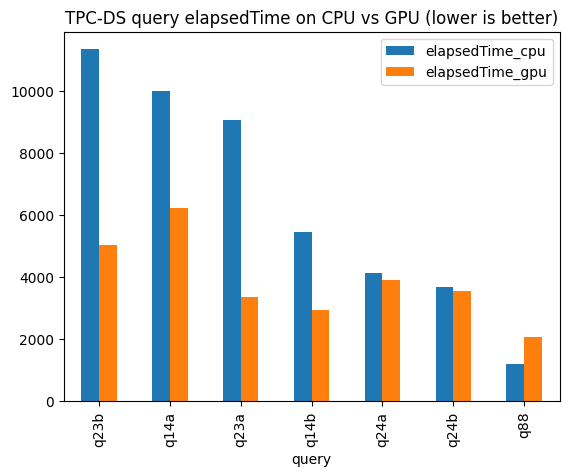

In [22]:
res.plot(title='TPC-DS query elapsedTime on CPU vs GPU (lower is better)', kind='bar', x='query', y=['elapsedTime_cpu', 'elapsedTime_gpu'])

<Axes: title={'center': 'Speedup factors of TPC-DS queries on GPU'}, xlabel='query'>

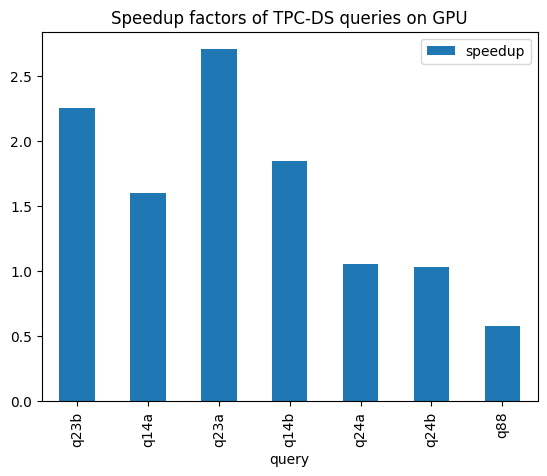

In [23]:
res.plot(title='Speedup factors of TPC-DS queries on GPU', kind='bar', x='query', y='speedup' )

# Run Queries interactively

In [24]:
query = 'q88'
with open(f"{tpcds_pyspark_files}/Queries/{query}.sql") as f:
  q = f.read()

In [25]:
print(q)

SELECT *
FROM
  (SELECT count(*) h8_30_to_9
  FROM store_sales, household_demographics, time_dim, store
  WHERE ss_sold_time_sk = time_dim.t_time_sk
    AND ss_hdemo_sk = household_demographics.hd_demo_sk
    AND ss_store_sk = s_store_sk
    AND time_dim.t_hour = 8
    AND time_dim.t_minute >= 30
    AND (
    (household_demographics.hd_dep_count = 4 AND household_demographics.hd_vehicle_count <= 4 + 2)
      OR
      (household_demographics.hd_dep_count = 2 AND household_demographics.hd_vehicle_count <= 2 + 2)
      OR
      (household_demographics.hd_dep_count = 0 AND
        household_demographics.hd_vehicle_count <= 0 + 2))
    AND store.s_store_name = 'ese') s1,
  (SELECT count(*) h9_to_9_30
  FROM store_sales, household_demographics, time_dim, store
  WHERE ss_sold_time_sk = time_dim.t_time_sk
    AND ss_hdemo_sk = household_demographics.hd_demo_sk
    AND ss_store_sk = s_store_sk
    AND time_dim.t_hour = 9
    AND time_dim.t_minute < 30
    AND (
    (household_demographics.hd_

In [26]:
spark.conf.set('spark.rapids.sql.enabled', True)
df  = spark.sql(q)
df.collect()

[Row(h8_30_to_9=18440, h9_to_9_30=39156, h9_30_to_10=38666, h10_to_10_30=58037, h10_30_to_11=58313, h11_to_11_30=34436, h11_30_to_12=33322, h12_to_12_30=39142)]

In [27]:
df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   GpuColumnarToRow false, [loreId=1508]
   +- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h12_to_12_30#73513L], 1073741824, [loreId=1507]
      :- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h11_30_to_12#73512L], 1073741824, [loreId=1506]
      :  :- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h11_to_11_30#73511L], 1073741824, [loreId=1505]
      :  :  :- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h10_30_to_11#73510L], 1073741824, [loreId=1504]
      :  :  :  :- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h10_to_10_30#73509L], 1073741824, [loreId=1503]
      :  :  :  :  :- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h9_30_to_10#73508L], 1073741824, [loreId=1502]
      :  :  :  :  :  :- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h9_to_9_30#73507L], 1073741824, [loreId=1501]
      :  :  :  :  :  :  :- GpuHashAggregate (keys=[], functions=[gpucount(1, false)]), filters=L

In [28]:
spark.conf.set('spark.rapids.sql.enabled', False)
df  = spark.sql(q)
df.collect()

[Row(h8_30_to_9=18440, h9_to_9_30=39156, h9_30_to_10=38666, h10_to_10_30=58037, h10_30_to_11=58313, h11_to_11_30=34436, h11_30_to_12=33322, h12_to_12_30=39142)]